# **Hepatitis C (HCV) Machine learning pipeline**

In [17]:
# Data science basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import pickle
# hyperparameter tuning
import optuna
# Terminal output control
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 19})

In [2]:
df = pd.read_csv("Hepatitis_C.csv")
X = df.drop(columns='label').to_numpy()
y = df.iloc[:, -1].to_numpy()
print("Data frame shape:", df.shape, "\nFeatures shape:",
      X.shape, "\nLabels shape", y.shape)
df.iloc[:, :-1]

Data frame shape: (204, 13) 
Features shape: (204, 12) 
Labels shape (204,)


,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
1,45,0,41.7,73.2,43.6,29.4,6.4,8.89,5.31,71.0,67.4,70.3
2,55,0,41.5,59.5,15.4,16.2,6.8,6.35,5.22,80.0,12.4,69.9
3,53,0,37.8,98.1,30.5,21.1,4.0,5.02,4.42,94.0,23.2,65.2
4,56,1,39.7,66.0,14.2,20.8,3.5,7.48,5.88,66.0,7.2,67.2
...,...,...,...,...,...,...,...,...,...,...,...,...
199,62,1,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
200,64,1,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
201,64,1,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
202,46,1,33.0,62.7,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


# **The steps of the baseline pipeline**

Before we build the complete pipeline we will present the individual steps of the pipeline. The pipeline is divided into the following steps:
- **Data preprocessing**
- **Cross Validation with Bayesian Optimization for model category evaluation**
- **Final Model Training**

Additionally after we enstablish the baseline pipeline we can enrich the pipeline with additional steps:
- **Feature Selection**

---

## *Data preprocessing*
As we verified in the exploratory data analysis notebook we have columns with different data types. Thus the sklearn `ColumnTransformer` provides a convenient way to preprocess the data. The `ColumnTransformer` allows us to apply different preprocessing steps to different columns. 

In our case we will use it to apply feature standardization $x = \frac{x - \mu}{\sigma}$ to the numerical columns that are not bianary.

In [18]:
# Define the columns to be scaled
columns_to_scale = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# Create a column transformer to scale the columns
preproccesing_pipeline = ColumnTransformer(transformers=[(
    'scaler', MinMaxScaler(), columns_to_scale)], remainder='passthrough')
X = preproccesing_pipeline.fit_transform(df.drop(columns='label').to_numpy())
new_cols = ['Age', 'ALB',	'ALP',	'ALT',	'AST',	'BIL',
            'CHE',	'CHOL',	'CREA',	'GGT',	'PROT', 'Sex']
new_df_features = pd.DataFrame(X, columns=new_cols)
new_df_features

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex
0,0.228070,0.540793,0.100419,0.115519,0.033355,0.067803,0.394263,0.483212,0.067221,0.041621,0.633333,0.0
1,0.456140,0.505828,0.152726,0.166083,0.055164,0.018239,0.498332,0.566423,0.058818,0.093803,0.494872,0.0
2,0.631579,0.501166,0.118924,0.056398,0.012829,0.019826,0.328886,0.553285,0.067221,0.008386,0.484615,0.0
3,0.596491,0.414918,0.214162,0.115130,0.028544,0.008723,0.240160,0.436496,0.080291,0.025159,0.364103,0.0
4,0.649123,0.459207,0.134962,0.051731,0.027582,0.006741,0.404270,0.649635,0.054150,0.000311,0.415385,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.754386,0.279720,1.000000,0.019448,0.314625,0.191118,0.276851,0.710949,0.044534,1.000000,0.448718,1.0
200,0.789474,0.093240,0.225759,0.007779,0.103271,0.072165,0.008005,0.232117,0.051349,0.044883,0.520513,1.0
201,0.789474,0.209790,0.187515,0.010113,0.278384,0.183188,0.016011,0.321168,0.054803,0.088834,0.794872,1.0
202,0.473684,0.303030,0.126820,0.148191,0.159718,0.072165,0.142762,0.404380,0.041079,0.066781,0.512821,1.0


---

## *Cross Validation with Bayesian Optimization*

In [19]:
# We import the class from the ClassifierCV_class.py file
from ClassifierCV_class import ClassifierCV

For this specific purpose we have created a custom class that to handle model category evaluation with nested cross validation trials that include automatic hyperparameter tuning. The class is called `ClassifierCV` and it is located with documenation in the `ClassifierCV_class.py` file. `ClassifierCV` is compatible with the sci-kit learn API and can be integrated into Pipelines.

it takes as input the following parameters:
  - `classifier_name`: Name of the classifier to be used for hyperparameter tuning (e.g. "KNeighborsClassifier")
  - `tuning_beta`: fbeta score in the tuning cv loop, choose beta < 1 to prioritize precision, beta > 1 to prioritize recall (Less FN) (default=1 == f1 score)
  - `model`: This is set to None, it will be used to store the best model after hyperparameter tuning
  - `class_weights`: dictionary in the form {class_label_1: weight_1,class_label_2,weight_2} to adjust the importance of classes in the training process (default={1: 1, 0: 1} $\leftarrow$ equal importance )
  - `seed`: Random seed for generating the seed array from which a seed is picked for each trial (default=42) 
  - `outer_folds`: Number of outer cross validation folds (default=5)
  - `tuning_folds`: Number of tuning cross validation folds, used in `fit_evaluate` as nested cv or in fit as simple cv (default=3) 
  - `shuffle`: Boolean to shuffle the data before splitting into folds (default=True)
  - `optimization_trials`: Number of trials optuna will perform to optimize the objective function (default=50)
  - `trial_num`: Number of trials to be performed for hyperparameter tuning (default=10)
  - `verbose`: Boolean, if Ture print the results of the fit method after the trials finish (default=True)

> The  `fit_transform` method takes as input the features X and the label y and runs `trial_num` nested cross validation trials with folds respective to `outer_folds`,`tuning_folds`. It returns all the scores across the cross validation lopps = `outer_folds`\*`number_of_trials` scores and their mean: f1, balanced accuracy, f2, recall, precision, ROC AUC, matthew mercer coefficient and negative predictive value. Also it returns the standard deviation of these scores. Finally it also returns the best model parameters found in the inner cross validation across all the cross validation loops.

> The `fit` method takes as input the features X and the label y and runs a non-nested cross validation of `tuning_folds`, to optimize a model. It is meant to be used to train and optimize the model on the whole training set after the best model category is found via `fit_evaluate`




Inside `ClassifierNCV` nested cross validation with hyperparameter tuning for ten model categories has been implemented:
  1. KNeighborsClassifier
  2. GaussianNB
  3. Ridge LogisticRegression
  4. Lasso LogisticRegression 
  5. Elastic LogisticRegression
  6. LinearDiscriminantAnalysis
  7. Polynomial kernel SVM
  8. Radial basis function kernel SVM
  9. Sigmoid kernel SVM
  10. Linear kernel SVM 

## *Final Model Training*

As mentioned in the exploratory data analysis in `data_exploration.ipynb`, the classes are imbalanced FILL MCC
Once we have decided based on the above scores to an optimal model category we use `ClassifierCV` and the `fit` method to train and optimize the hyperparameters of the best model category on the whole training set, via cross validation. 

---

# **Wrapping things up in a pipeline**

Now that we have explained each individual step of the pipeline we can finally wrap things up in one. Since our custom class: `ClassifierCV` follows the guidelines for custom estimators, it can be integrated directly into any sci-kit learn API and into the `Pipeline` class.

For the base pipeline we utilize:
   1. `Columntransformer`, to standardize non-binary numerical features, which we pass in the `columns_to_normalize` list.
   2. Our custom `ClassifierCV`, with the `fit_evaluate` model for a nested cross validation of 10 trials, 5 outer and 3 inner folds for a total fo 50 outer cross validation loops
   4. `ClassifierCV` with the `fit` method for a non nested tuning 5fold cross validation loop on the whole dataset X to fit and tune the best classifier categorym identified at the previous step. The python pickle library is used to convert the final model into a bytestream and save it.

We wrap this pipeline in a for loop to iterate over and perform nested cross validation for all classifier of interest in the list: `classifier_names` and find the one with the highest Math

In [20]:
columns_to_standardize = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
classifier_names = ['GaussianNB',
                    'KNeighborsclassifier',
                    'LinearDiscriminantAnalysis',
                    'LogisticRegression-ridge',
                    'LogisticRegression-lasso',
                    'LogisticRegression-elastic',
                    'SVC-poly',
                    'SVC-sigmoid',
                    'SVC-rbf',
                    'SVC-linear']

We create the function `choose_best` to extract the mean Mathews coefficient score of each classifier once the pipeline has been completed, after the 50 cross validation loops and pick the classifier category with the highest mean.

In [21]:
def choose_best(scores_list):
    """Function to find the mean MCC score of each classifier after the pipeline completes
    and print the one with the highest mean"""
    mean_mcc_scores = [df["MCC"].mean() for df in scores_list]
    stdv_mcc_scores = [df["MCC"].std() for df in scores_list]
    best_idx = np.argmax(mean_mcc_scores)
    print(f"\nThe optimal classifier category is: {classifier_names[best_idx]} \n\
    mean MCC score {round(mean_mcc_scores[best_idx],3)}, variance {round(stdv_mcc_scores[best_idx],3)}")
    return best_idx

Pipeline:

In [22]:
# Initialize the features and target labels again
X = df.drop(columns='label').to_numpy()
y = df.iloc[:, -1].to_numpy()

# List to store the total scores and parameters for each classifier
scores_list = []
parameter_list = []

# PIPELINE
# Loop through classifiers and initialize a ClassifierCV class object for each one
for classifier_name in classifier_names:
    nested_crossval_scoring = ClassifierCV(
        classifier_name=classifier_name, verbose=False, tuning_beta=2, class_weight={0: 1, 1: 2})
    print(f"Beginning pipeline for {classifier_name}")

    ################## nested Pipeline ###################################################
    model_nestedCV_pipeline = Pipeline([('preprocessing', preproccesing_pipeline),
                                        ('nested cross validation', nested_crossval_scoring)])
    ###############################################################################
    # Execute the pipeline
    scores, parameters = model_nestedCV_pipeline.fit_transform(X, y)
    # Store the scores of each model in a list
    scores_list.append(scores)
    parameter_list.append(parameters)
# Find the mean of the mcc scors and pick the index of the model with the highest

Beginning pipeline for GaussianNB
Beginning pipeline for KNeighborsclassifier
Beginning pipeline for LinearDiscriminantAnalysis
Beginning pipeline for LogisticRegression-ridge
Beginning pipeline for LogisticRegression-lasso
Beginning pipeline for LogisticRegression-elastic
Beginning pipeline for SVC-poly
Beginning pipeline for SVC-sigmoid
Beginning pipeline for SVC-rbf
Beginning pipeline for SVC-linear


In [23]:
best_idx = choose_best(scores_list)
# Fit the final model
final_tuner = ClassifierCV(
    classifier_name=classifier_names[best_idx], tuning_beta=2, class_weight={0: 1, 1: 2}, tuning_folds=5, optimization_trials=100)
final_model = model_nestedCV_pipeline.fit(X, y)
# print the final model
print("\n The final model, fitted and optimized for all the dataset X is:\n")
print(final_model)

# Save the final model
filename = 'finalized_model.pickle'
pickle.dump(final_model, open(filename, 'wb'))


The optimal classifier category is: SVC-linear 
    mean MCC score 0.83, variance 0.098


[W 2023-04-24 14:32:40,703] Trial 6 failed with parameters: {'C': 5.878248012875521} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\cinna\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\cinna\Desktop\DS_MSc\Semester 2\Machine learning in CB\Assignment_2\ClassifierCV_class.py", line 256, in objective
    self.model.fit(X_inner_train, y_inner_train)
  File "c:\Users\cinna\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "c:\Users\cinna\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
KeyboardInterrupt
[W 2023-04-24 14:32:40,715] Trial 6 failed with value None.


KeyboardInterrupt: 

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

## *Plots of the Results*

In order to obtain a better understanding of the resulting scores and the model parameters, we utilize graphical representations

### Functions to create the plots

In [12]:
def plot_heatmap(classifier_names, total_scores_list, title, save=False, save_name="heatmap"):
    """Void function to plot a heatmap of the the mean and standard deviation per classification 
    algorithm and metric across the CV loops"""
    stdv_scores_df = pd.DataFrame(
        dict(zip(classifier_names, [df.std(axis=0) for df in total_scores_list])))
    mean_scores_df = pd.DataFrame(
        dict(zip(classifier_names, [df.mean(axis=0) for df in total_scores_list])))
    fig, ax = plt.subplots(1, 2, figsize=(
        15, 8), dpi=130, sharey='all', layout='constrained')
    ax[0].set_title("Mean Scores")
    ax[1].set_title("Mean Standard Deviation")
    sns.heatmap(mean_scores_df.T, annot=True,
                fmt=".3f", cmap="rocket", ax=ax[0], annot_kws={"size": 12})
    sns.heatmap(stdv_scores_df.T, annot=True,
                fmt=".3f", cmap="rocket", ax=ax[1], annot_kws={"size": 12})
    fig.suptitle(title, fontsize=25)
    fig.supxlabel("\nClassification Metric")
    fig.supylabel("Classifier Category\n")
    if save:
        fig.savefig(fname=f"images/{save_name}.png",
                    dpi=300, format='png',  bbox_inches='tight')
    else:
        pass
    fig.show()


def plot_boxplot(classifier_names, total_scores_list, title, save=False, save_name="metric_boxplot"):
    """Void function to plot the distribution of classificiaiton metrics per classification 
    algorithm across the CV loops"""
    fig, ax = plt.subplots(2, 5, figsize=(20, 10), sharex='all',
                           sharey='all', layout='constrained')
    counter = 0
    for scores in total_scores_list:
        sns.boxplot(scores, ax=ax[counter % 2, counter // 2])
        ax[counter % 2, counter // 2].set_title(classifier_names[counter])
        ax[counter % 2, counter // 2].grid(alpha=0.5)
        ax[counter % 2, counter // 2].set_yticks(np.arange(0, 1.1, 0.1))
        ax[counter % 2, counter // 2].tick_params(axis='x', rotation=90)
        counter += 1
        fig.supxlabel("\nClassification metric")
        fig.supylabel("Score distribution\n")
        fig.suptitle(title, fontsize=25)
    if save:
        fig.savefig(fname=f"images/{save_name}.png",
                    dpi=300, format='png',  bbox_inches='tight')
    fig.show()


def plot_C_parameter_pdf(classifier_names, parameters_list, title, save=False,  save_name="regularization_C"):
    """Void function to plot the pdfs of the C hyper parameter for classifier algorithm the parameter
    applies"""
    lr_SVM_parameters = parameters_list[3:]
    fig, ax = plt.subplots(2, 4, figsize=(
        20, 10), layout='constrained')
    counter = 0
    for parameters in lr_SVM_parameters:
        temp_df = pd.DataFrame(parameters)
        ax[counter % 2, counter // 2].set_xlim(0.001, 1000)
        sns.kdeplot(x=temp_df["C"], ax=ax[counter % 2, counter //
                    2], fill=True, log_scale=True)
        ax[counter % 2, counter // 2].set_title(classifier_names[3:][counter])
        ax[counter % 2, counter // 2].grid(alpha=0.5)
        counter += 1
        if counter == 7:
            fig.delaxes(ax[counter % 2, counter // 2])
        fig.suptitle(title)
    if save:
        fig.savefig(fname=f"images/{save_name}.png",
                    dpi=300, format='png',  bbox_inches='tight')
    fig.show()


def plot_C_gamma_joint_pdf(classifier_names, parameters_list, title, save=False,  save_name="regularization_joint"):
    """Void function to plot the joint pdfs of the C and gamma hypeparameters
    for classifier algorithms the parameters apply"""
    lr_SVM_parameters = parameters_list[6:-1]
    fig, ax = plt.subplots(1, 3, figsize=(
        20, 6), layout='constrained')
    counter = 0
    for parameters in lr_SVM_parameters:
        temp_df = pd.DataFrame(parameters)
        ax[counter].set_xlim(0.001, 100)
        ax[counter].set_ylim(0.001, 100)
        sns.kdeplot(x=temp_df["C"], y=temp_df['gamma'], ax=ax[counter],
                    fill=True, cmap="coolwarm", cbar=True,  log_scale=True)
        ax[counter].set_title(classifier_names[6:][counter])
        ax[counter].grid()
        counter += 1
        fig.suptitle(title)
    if save:
        fig.savefig(fname=f"images/{save_name}.png",
                    dpi=300, format='png',  bbox_inches='tight')
    fig.show()

### Heatmap of mean and standard deviation per classification algorithm and metric

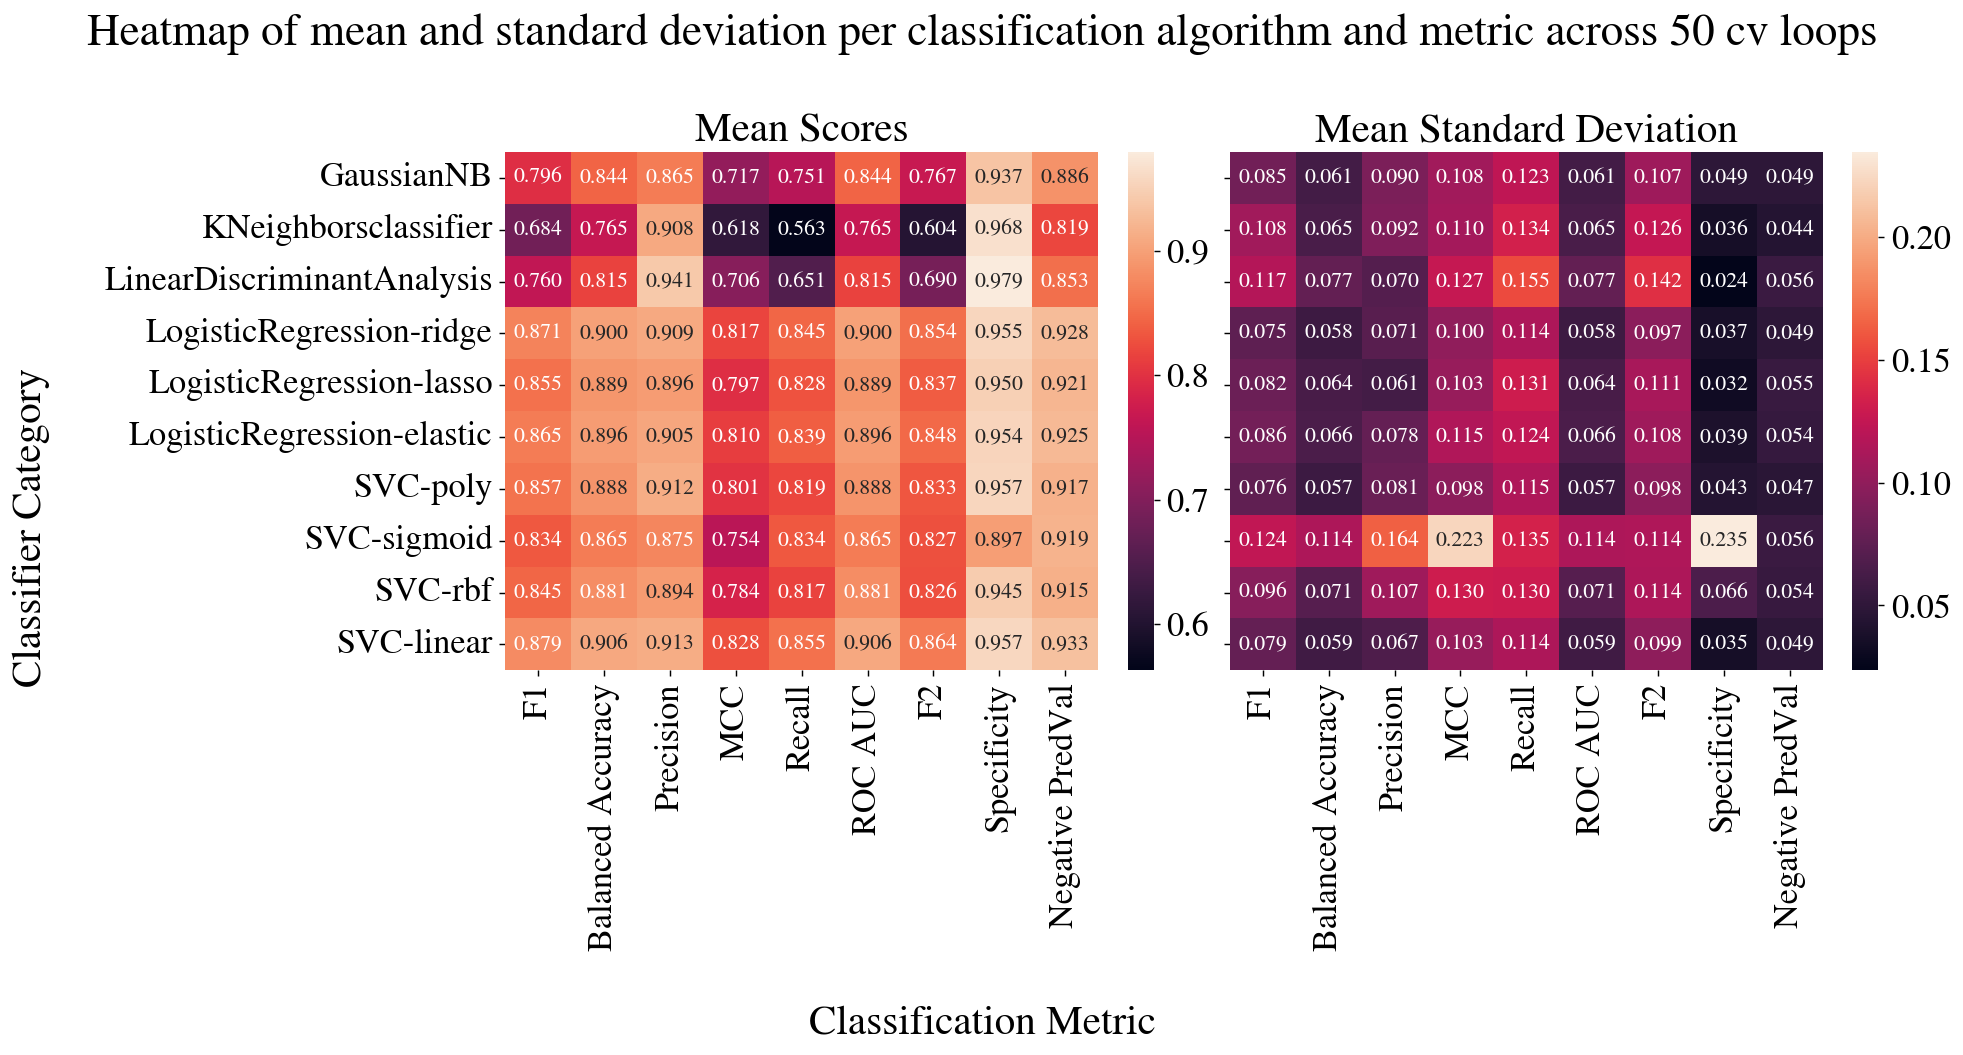

In [25]:
plot_heatmap(classifier_names, scores_list, save=False, save_name="Normilization_heatmap",
             title="Heatmap of mean and standard deviation per classification algorithm and metric across 50 cv loops\n")

### BoxPlot of classification metrics across the 50 nested cross validation loops

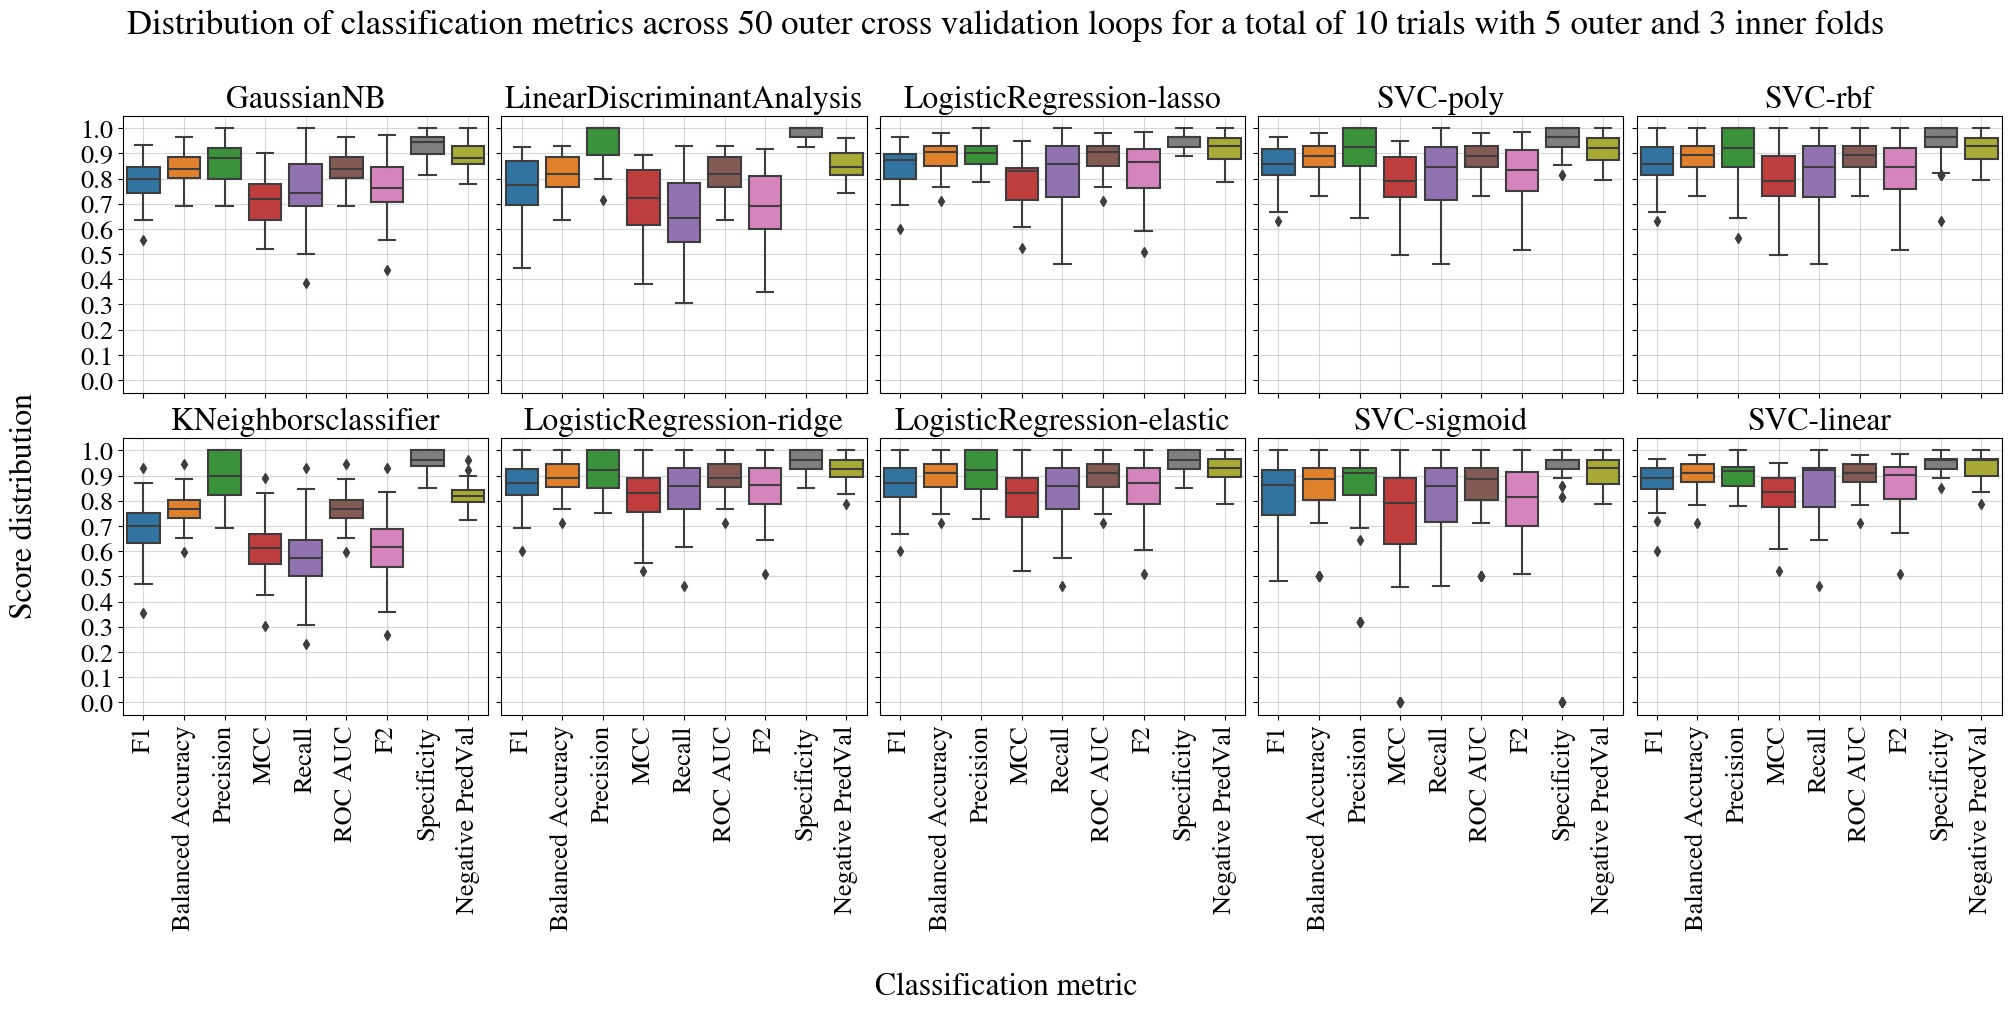

In [22]:
plot_boxplot(classifier_names, scores_list, save=True, save_name="metric_boxplot",
             title="Distribution of classification metrics across 50 outer cross validation loops for a total of 10 trials with 5 outer and 3 inner folds\n")

### Kernel Density Estimation plot of the Inverse of the regularization strength parameter C

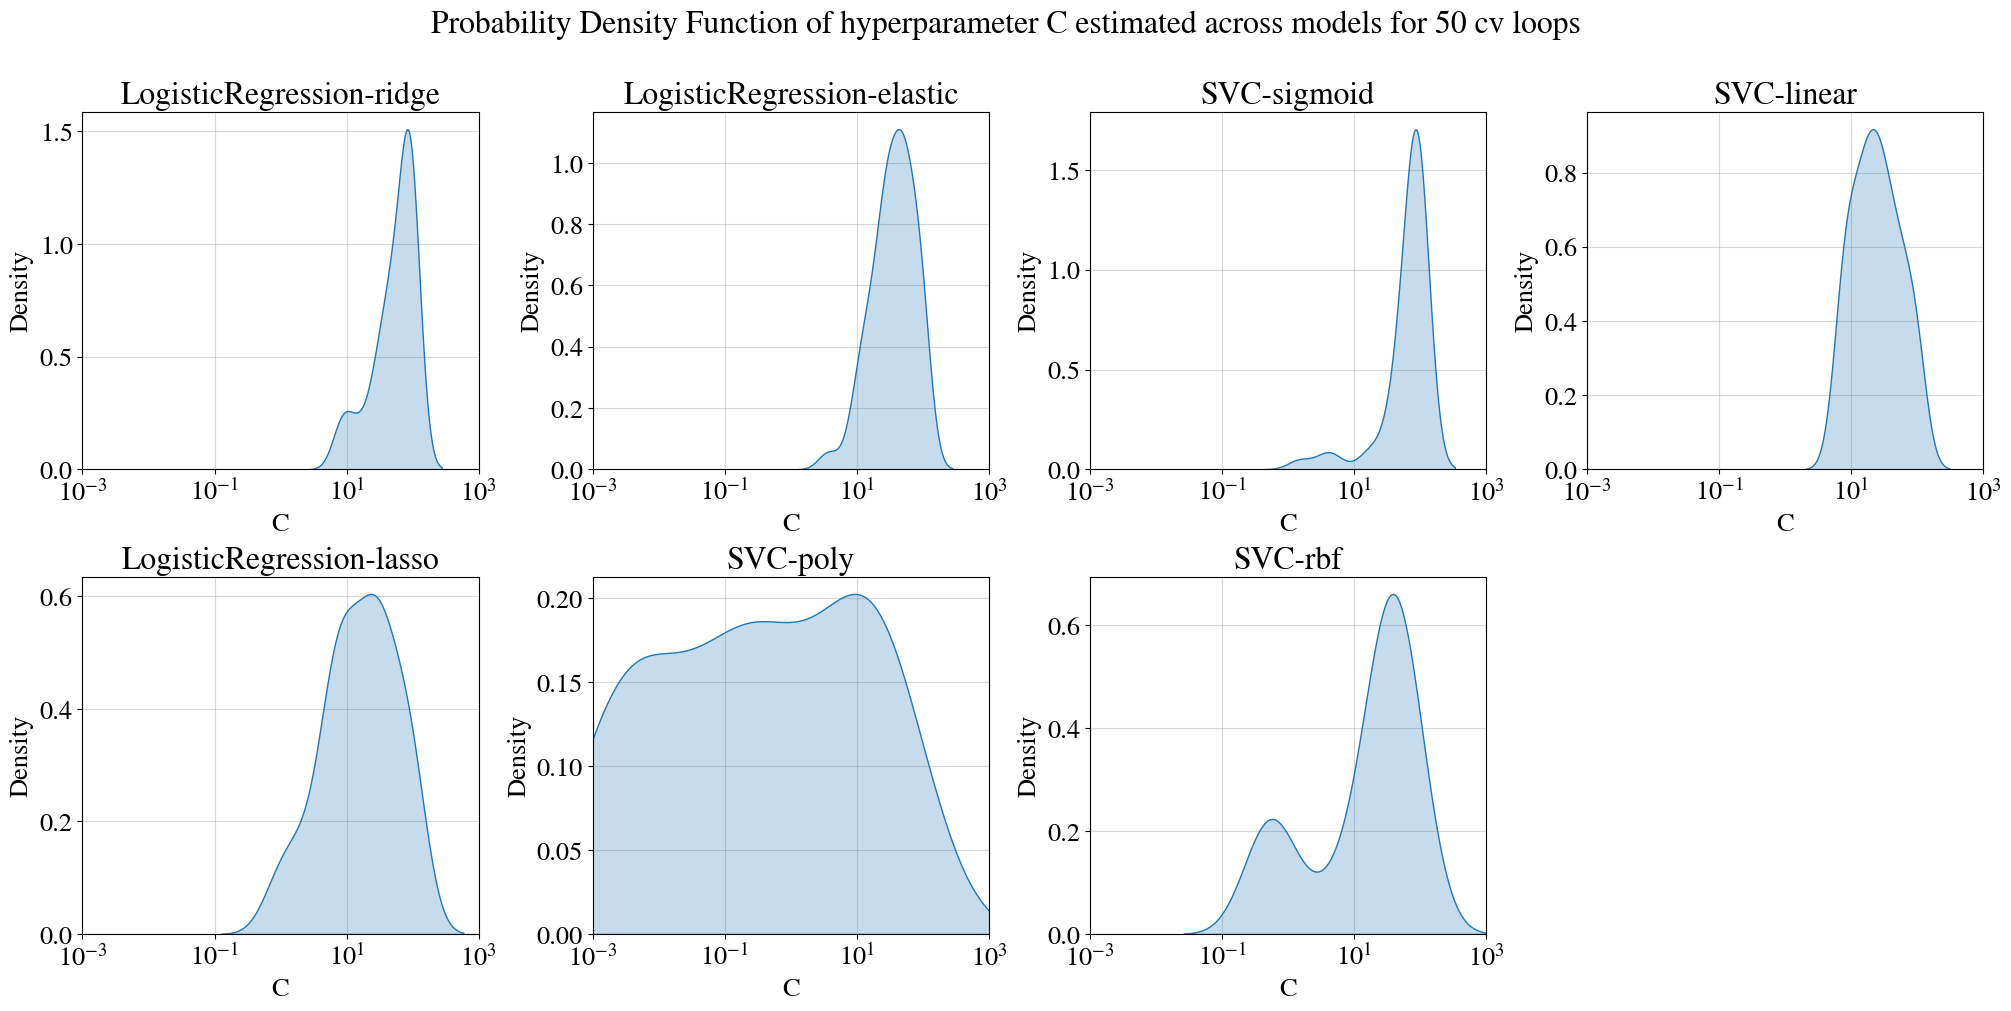

In [31]:
plot_C_parameter_pdf(classifier_names, parameter_list, save=False, save_name="c_parameter_proba",
                     title="Probability Density Function of hyperparameter C estimated across models for 50 cv loops\n")

## Joint probability Density function of C and gamma

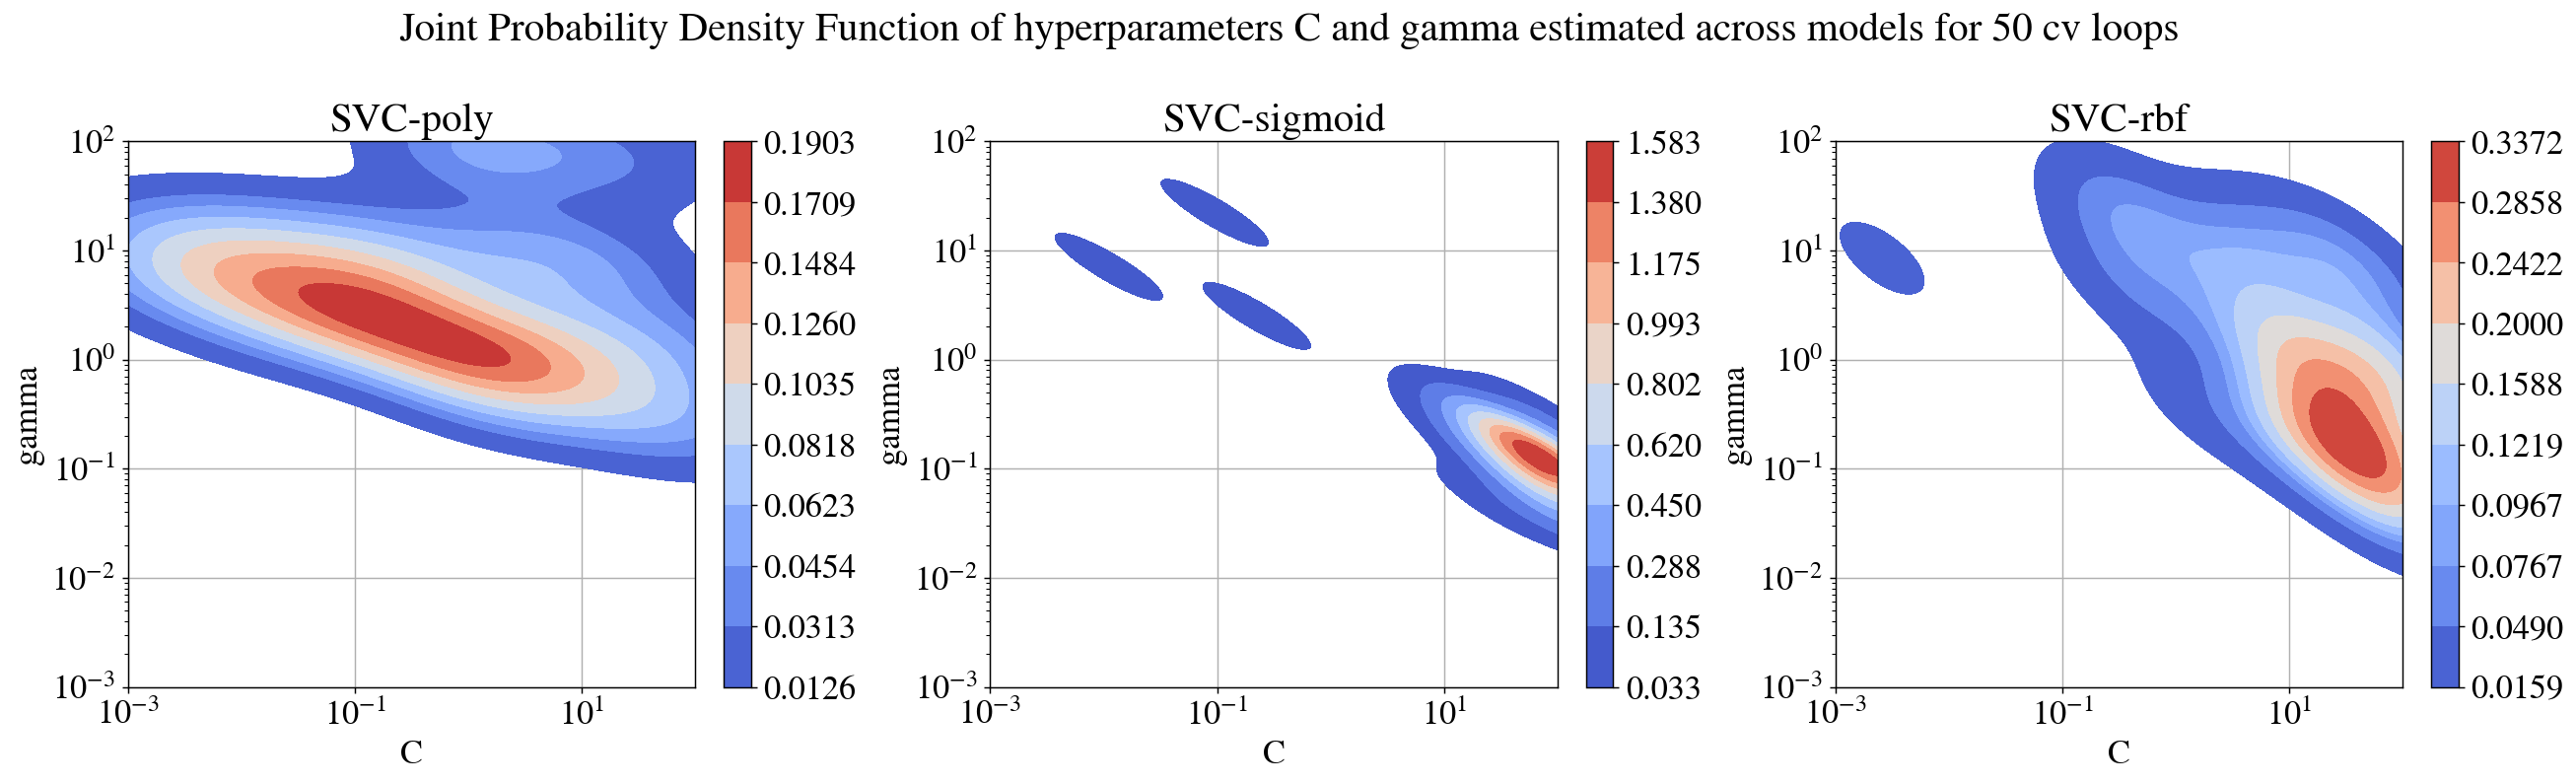

In [24]:
plot_C_gamma_joint_pdf(classifier_names, parameter_list,
                       title="Joint Probability Density Function of hyperparameters C and gamma estimated across models for 50 cv loops\n")

# **Can we do better? Extending the pipeline to include two different feature selection methods**

## *Top 5 feature selection based on Information Gain with Mutual information Criterion*

For the extended pipeline with feature selection we utilize:
   1. `Columntransformer`, to standardize non-binary numerical features, which we pass in the `columns_to_standardize` list.
   2. The `SelectKBest` class wrapped around `mutual_info_classif` for feature selection of the top 5 (k=5), features that provide the most information gain for the target labels.
   3. Our custom `ClassifierCV`, with the `fit_evaluate` model for a nested cross validation of 10 trials, 5 outer and 3 inner folds for a total fo 50 outer cross validation loops

In [33]:
# Initialize the features and target labels again
X = df.drop(columns='label').to_numpy()
y = df.iloc[:, -1].to_numpy()

# Define the pipeline steps
column_transformer = ColumnTransformer(transformers=[(
    'scaler', MinMaxScaler(), columns_to_standardize)], remainder='passthrough')

# List to store the total scores and parameters for each classifier
scores_list_with_mi = []
parameter_list_with_mi = []

# Loop through classifiers and initialize a ClassifierCV class object for each one
for classifier_name in classifier_names:
    nested_crossval_scoring = ClassifierCV(
        classifier_name=classifier_name, verbose=False, tuning_beta=4, class_weight={1: 2, 0: 1})
    print(f"Beginning pipeline for {classifier_name}")

    ################## Pipeline ###################################################
    model_nestedCV_pipeline = Pipeline([('preprocessing', column_transformer),
                                        ('feature selection', SelectKBest(
                                            mutual_info_classif, k=5)),
                                        ('nested cross validation', nested_crossval_scoring)])
    #######################################################################################
    # Execute the pipeline
    scores, parameters = model_nestedCV_pipeline.fit_transform(X, y)

    mask = model_nestedCV_pipeline.named_steps['feature selection'].get_support(
    )
    print(f"Selected Features: {new_df_features.columns[mask]}")

    # Store the scores of each model in a list
    scores_list_with_mi.append(scores)
    parameter_list_with_mi.append(parameters)

# Find the mean of the mcc scors and pick the model with the highest
best_idx = choose_best(scores_list_with_mi)

Beginning pipeline for GaussianNB
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for KNeighborsclassifier
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for LinearDiscriminantAnalysis
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for LogisticRegression-ridge
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for LogisticRegression-lasso
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for LogisticRegression-elastic
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for SVC-poly
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for SVC-sigmoid
Selected Features: Index(['ALB', 'ALP', 'AST', 'BIL', 'GGT'], dtype='object')
Beginning pipeline for SVC-rbf
Sele

6

### Plots of the results

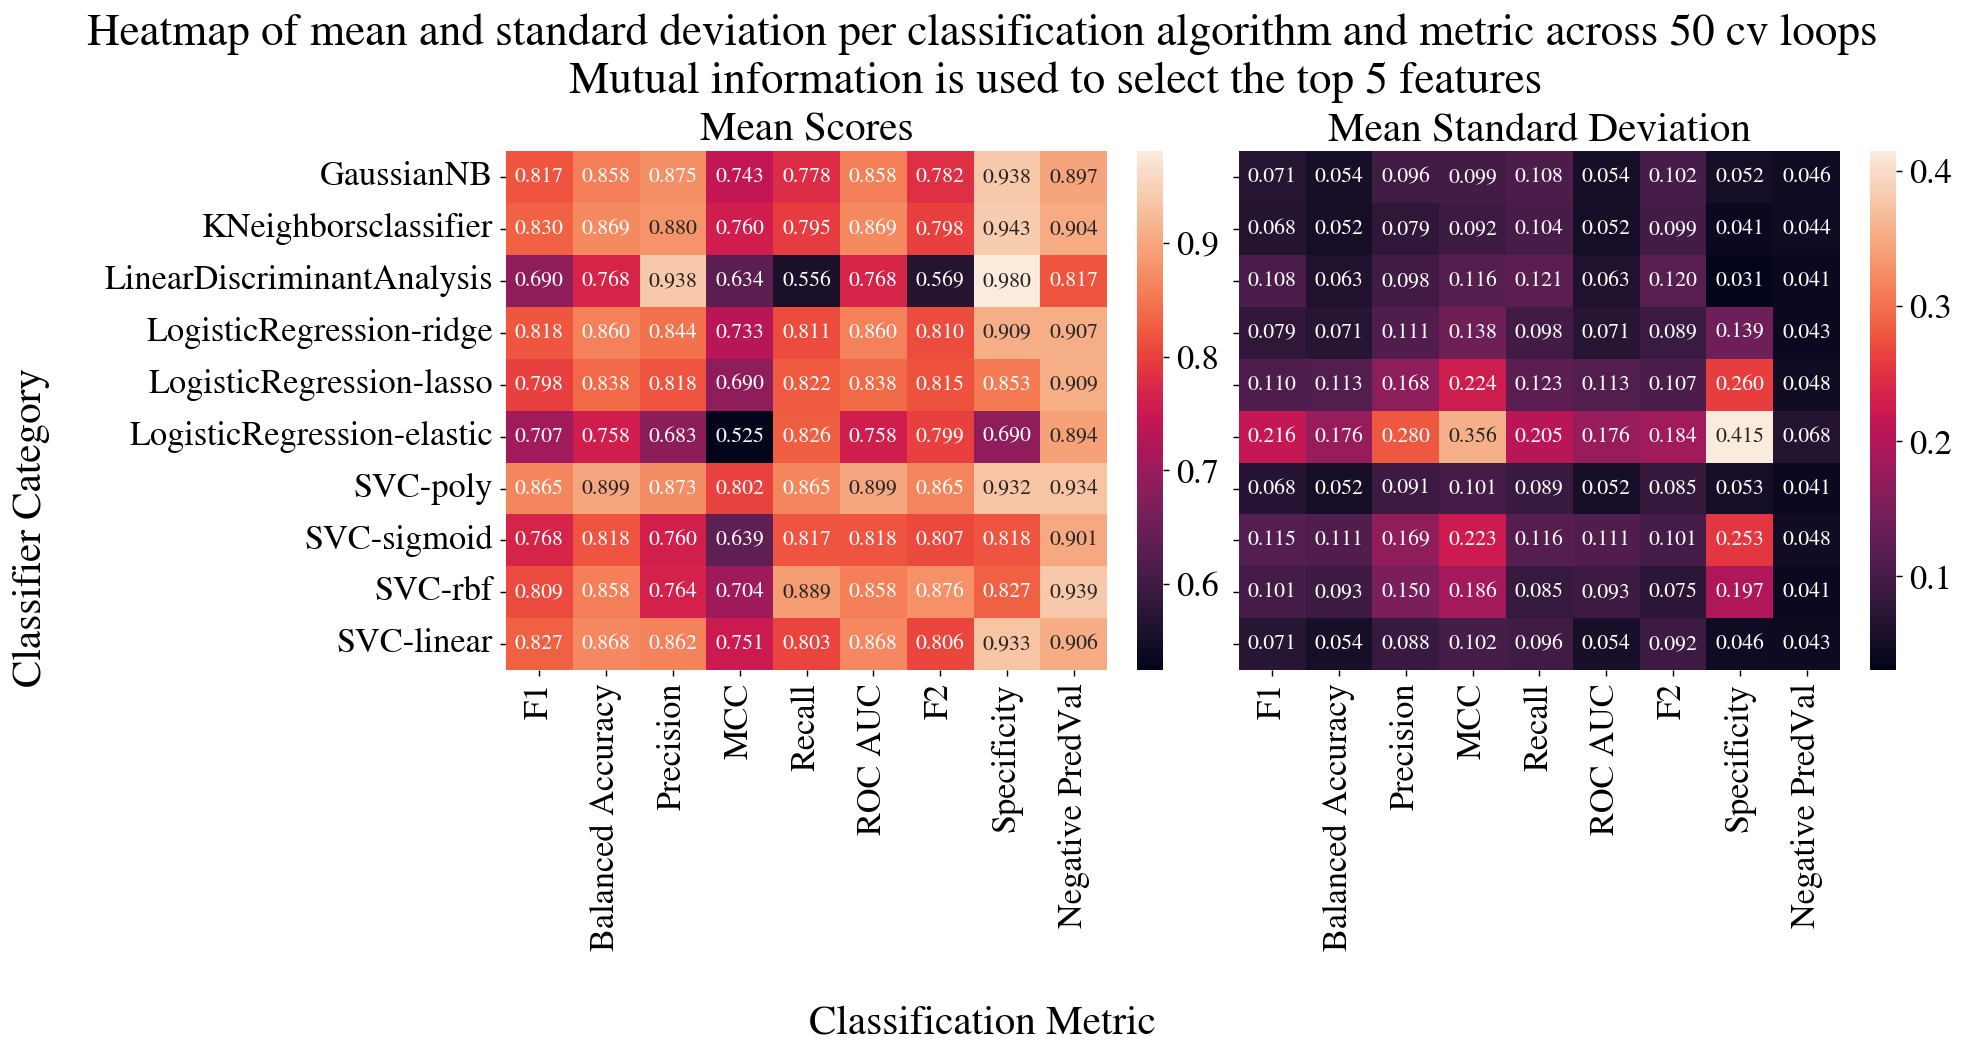

In [34]:
plot_heatmap(classifier_names, scores_list_with_mi, save=True, save_name="MI_heatmap", title="Heatmap of mean and standard deviation per classification algorithm and metric across 50 cv loops\n\
             Mutual information is used to select the top 5 features")

## *Top 5 feature selection based on feature F-score with ANOVA*

In [15]:
# Initialize the features and target labels again
X = df.drop(columns='label').to_numpy()
y = df.iloc[:, -1].to_numpy()

# Define the pipeline steps
column_transformer = ColumnTransformer(transformers=[(
    'scaler', MinMaxScaler(), columns_to_standardize)], remainder='passthrough')

# List to store the total scores and parameters for each classifier
scores_list_with_anova = []
parameter_list_with_anova = []

# Loop through classifiers and initialize a ClassifierCV class object for each one
for classifier_name in classifier_names:
    nested_crossval_scoring = ClassifierCV(
        classifier_name=classifier_name, verbose=False, tuning_beta=2)
    print(f"Beginning pipeline for {classifier_name}")
    # Skip the polynomial classifier since it fails to converge after 70 minutes
    if classifier_name == 'SVC-poly':
        pass
    else:
        ######################## Pipeline ###################################################
        model_nestedCV_pipeline = Pipeline([('preprocessing', column_transformer),
                                            ('feature selection', SelectKBest(
                                                f_classif, k=5)),
                                            ('nested cross validation', nested_crossval_scoring)])
    #######################################################################################
    # Execute the pipeline
    scores, parameters = model_nestedCV_pipeline.fit_transform(X, y)

    mask = model_nestedCV_pipeline.named_steps['feature selection'].get_support(
    )
    print(f"Selected Features: {new_df_features.columns[mask]}")

    # Store the scores of each model in a list
    scores_list_with_anova.append(scores)
    parameter_list_with_anova.append(parameters)

# Find the mean of the mcc scors and pick the model with the highest
best_idx = choose_best(scores_list_with_anova)

Beginning pipeline for GaussianNB
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for KNeighborsclassifier
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for LinearDiscriminantAnalysis
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for LogisticRegression-ridge
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for LogisticRegression-lasso
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for LogisticRegression-elastic
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for SVC-poly
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for SVC-sigmoid
Selected Features: Index(['AST', 'BIL', 'CHE', 'CHOL', 'GGT'], dtype='object')
Beginning pipeline for SVC-

### Plots of the Results

In [14]:
scores_list

NameError: name 'scores_list' is not defined

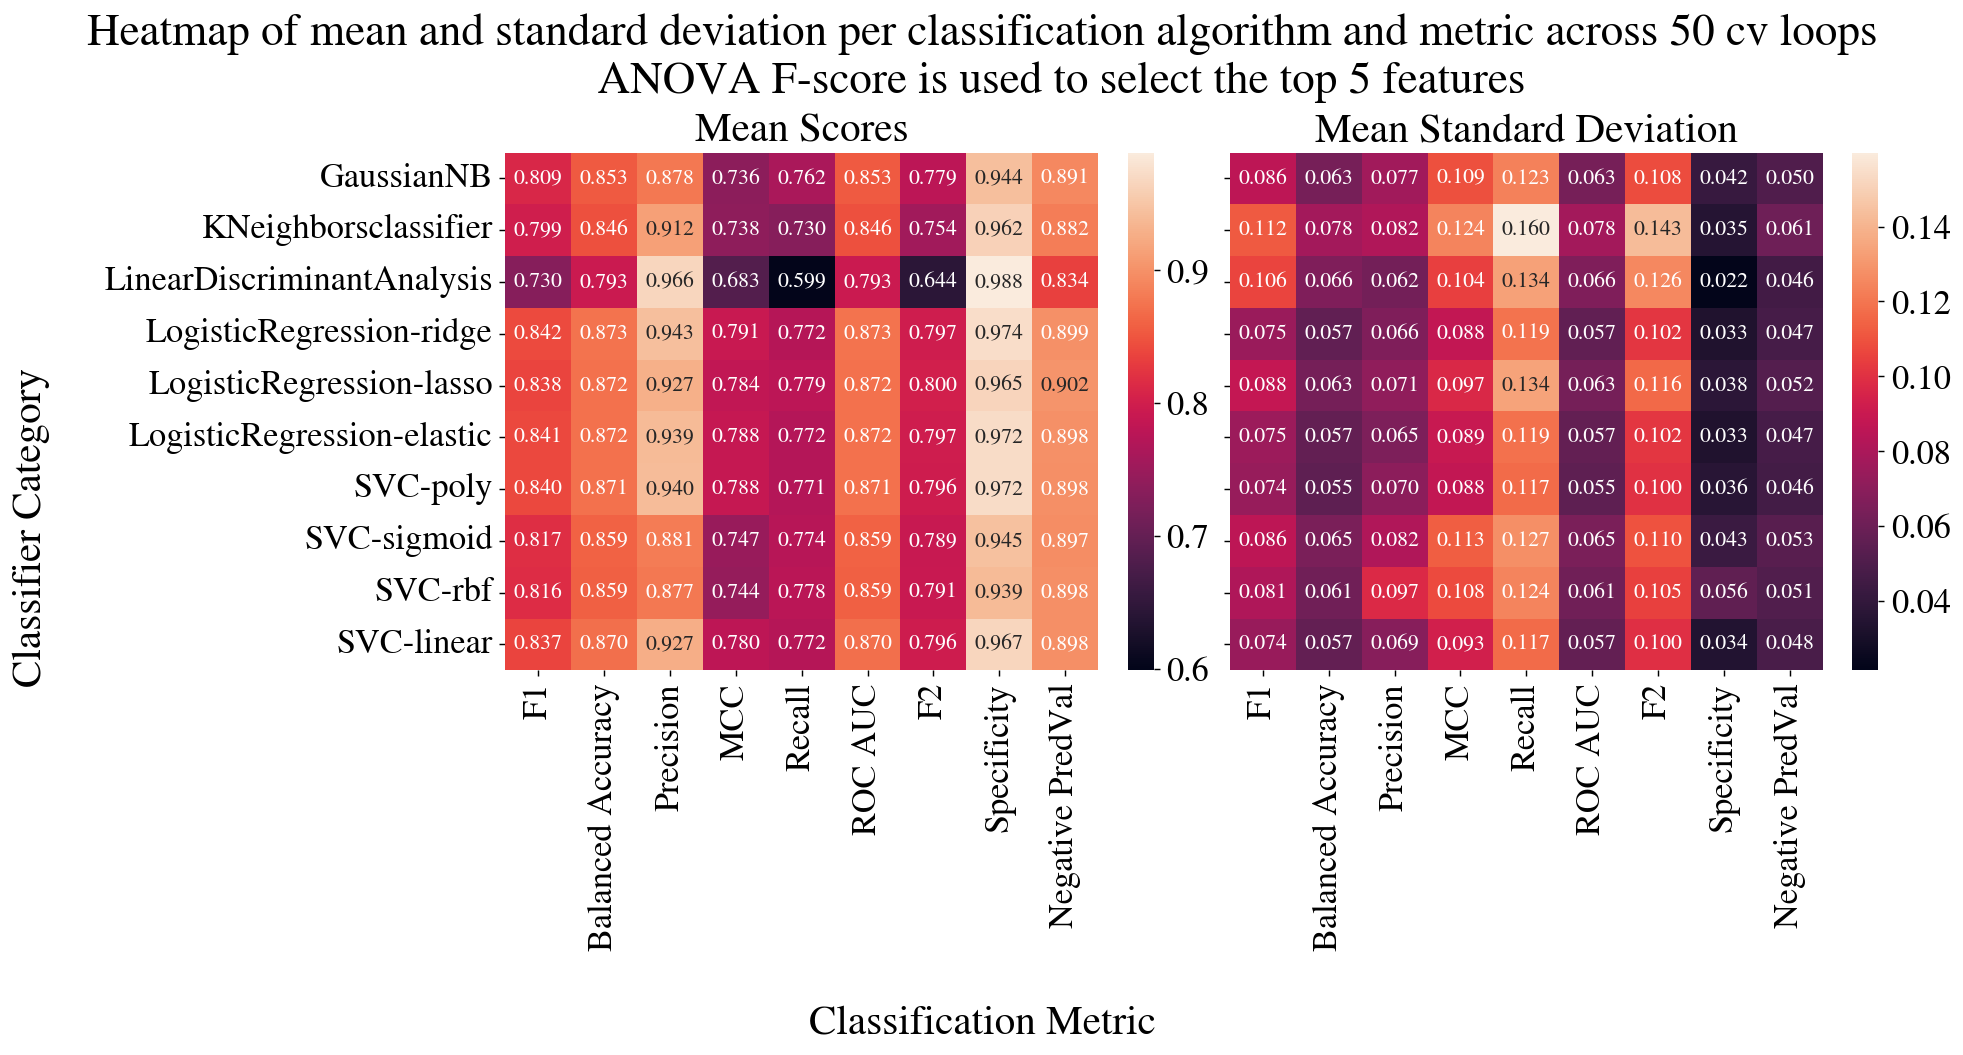

In [13]:
plot_heatmap(classifier_names, scores_list_with_anova, title="Heatmap of mean and standard deviation per classification algorithm and metric across 50 cv loops\n\
              ANOVA F-score is used to select the top 5 features")